In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

from lesson_functions import *

from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label

    



/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
# Read in cars and notcars
cars = []
notcars = []

import glob

cars = glob.glob('/data/vehicles/*/*.png')
notcars = glob.glob('/data/non-vehicles/*/*.png')


In [33]:
# paramaters

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

xy_window_size = (64, 64)
xy_overlap_size = (0.75, 0.75)

y_start_stop = [400, 720] # Min and max in y to search in slide_window()



In [4]:
# Extract features
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Normalise images
X = (X - X.mean()) / (X.max() - X.min())


# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
# Split up data into randomized training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


In [5]:
# Train classifier

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
training_time = round(t2-t, 4)
print(training_time, 'Seconds to train SVC...')
# Check the score of the SVC
svc_score = round(svc.score(X_test, y_test), 4)
print('Test Accuracy of SVC = ', svc_score)
# Check the prediction time for a single sample
t=time.time()


77.4465 Seconds to train SVC...
Test Accuracy of SVC =  0.9893


In [6]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5), polygon_mask=None):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    #window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = np.int(xs*nx_pix_per_step + x_start_stop[0])
            endx = np.int(startx + xy_window[0])
            starty = np.int(ys*ny_pix_per_step + y_start_stop[0])
            endy = np.int(starty + xy_window[1])
            
            # Append window position to list
            if polygon_mask is not None:
                if polygon_mask[int(starty)][int(startx)] > 0:
                    # Append window position to list
                    window_list.append(((startx, starty), (endx, endy)))
            else:
                window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return 

In [7]:
def find_windows(image):
    global window_list
    window_list = []
    
    """
    xy_window_size = (64,64)
    windows = (slide_window(image, x_start_stop=[500, None], y_start_stop=y_start_stop, 
                        xy_window=xy_window_size, xy_overlap=xy_overlap_size, polygon_mask=mask))
    """
    xy_overlap_size = (0.75, 0.75)
    
    """
    xy_window_size = (32,32)
    y_start_stop = [400, 448]
    (slide_window(image, x_start_stop=[500, None], y_start_stop=y_start_stop, 
                        xy_window=xy_window_size, xy_overlap=xy_overlap_size, polygon_mask=mask))
    """
    
    xy_window_size = (48,48)
    y_start_stop = [400, 464]
    (slide_window(image, x_start_stop=[500, None], y_start_stop=y_start_stop, 
                        xy_window=xy_window_size, xy_overlap=xy_overlap_size, polygon_mask=mask))
    
    xy_window_size = (64,64)
    y_start_stop = [400, 544]
    (slide_window(image, x_start_stop=[500, None], y_start_stop=y_start_stop, 
                        xy_window=xy_window_size, xy_overlap=xy_overlap_size, polygon_mask=mask))
    
    xy_window_size = (96,96)
    y_start_stop = [400, 592]
    (slide_window(image, x_start_stop=[500, None], y_start_stop=y_start_stop, 
                        xy_window=xy_window_size, xy_overlap=xy_overlap_size, polygon_mask=mask))
    
    xy_window_size = (128,128)
    y_start_stop = [400, 616]
    (slide_window(image, x_start_stop=[500, None], y_start_stop=y_start_stop, 
                        xy_window=xy_window_size, xy_overlap=xy_overlap_size, polygon_mask=mask))
    
    
    
    return window_list

In [30]:
def draw_on_image(testimage_number):
    # Read in image
    image = mpimg.imread('test_images/test' + str(testimage_number) + '.jpg')
    draw_image = np.copy(image)

    # Rescale data since training data extracted from 
    # .png images (scaled 0 to 1 by mpimg) and image we
    # are searching is .jpg (scaled 0 to 255)
    image = image.astype(np.float32)/255
    
    # Normalise image
    # image = normalise(image)
    # print(image, image.shape)
    
    # Get list of windows to search at this stage.
    
    windows = find_windows(image)
    #windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
    #                    xy_window=xy_window_size, xy_overlap=xy_overlap_size, polygon_mask=mask)
    
    
#    window_img_eg = draw_boxes(draw_image, windows, color=(0, 0, 255), thick=2)                    

    # Plot image with bounding boxes drawn.
    #plt.title(image_title)
#    plt.figure(figsize=(15,15))
#    plt.imshow(window_img_eg)
    
    
    # Return all the windows the classifier has predicted contain car(s) ('positive windows').
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
#    print("Hot windows: ", hot_windows)

    # Draw bounding boxes around the windows that the classifier predicted has cars in them
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=2)                    

    # Plot image with bounding boxes drawn.
    #plt.title(image_title)
    plt.figure(figsize=(15,15))
    plt.imshow(window_img)
    #plt.savefig(image_file_name + "_window_test" + str(testimage_number) + ".png")
    
    

In [31]:
mask = np.zeros_like(mpimg.imread('test_images/test1.jpg')[:,:,0])
vertices = np.array([[(700,400),(1000,620),(1280,620),(1280,400)]])
mask = cv2.fillPoly(mask, vertices, 1)

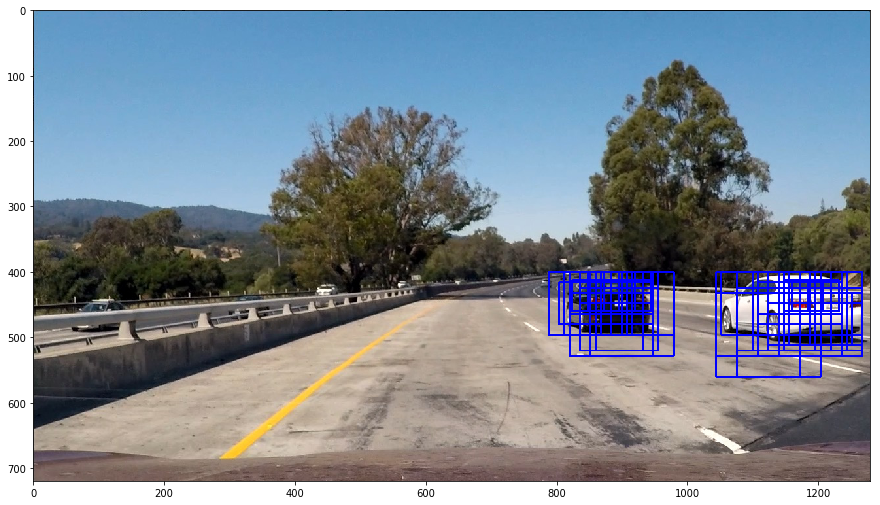

In [32]:
draw_on_image(1)

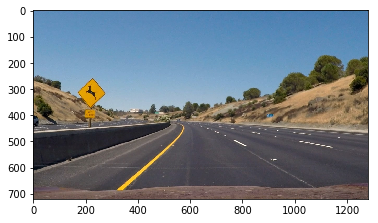

In [11]:
draw_on_image(2)

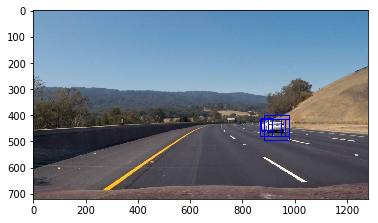

In [12]:
draw_on_image(3)

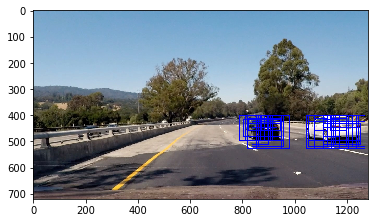

In [13]:
draw_on_image(4)

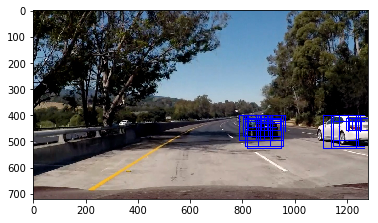

In [14]:
draw_on_image(5)

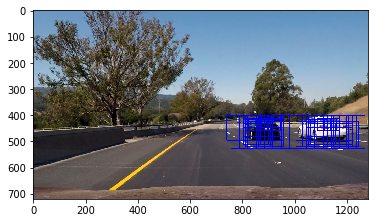

In [15]:
draw_on_image(6)

In [16]:
def search_windows(img, windows, clf, scaler, color_space='YCrCb', 
                    spatial_size=(32, 32), hist_bins=16, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel="ALL", spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        #print(window[0][1])
        test_img = cv2.resize(img[np.int(window[0][1]):np.int(window[1][1]), np.int(window[0][0]):np.int(window[1][0])], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [17]:
def add_bboxes(input_image, windows, classifier, scaler, draw=True):
    """Adds bounding boxes from `input_image` (one array of arrays) to
    the global variable `bboxes_list`'.
    If `draw` is True, returns image overlaid with bounding boxes.
    """
    
    global bboxes_list
    
    hot_windows = search_windows(input_image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
#    print("Hot windows: ", hot_windows)
    bboxes_list.append(hot_windows)
    if draw == True:
        draw_image = np.copy(input_image)
        window_img = draw_boxes(input_image, hot_windows, color=(0, 0, 255), thick=6)
        return window_img

In [18]:
def add_heat(heatmap, box_list):
    """Returns `heatmap` with bounding boxes in `bbox_list` added to it.
    `bbox_list` is an array of boxes.

    This function should be applied per frame.
    """
    # Iterate through list of bboxes
    for box in box_list:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

In [19]:
def draw_labeled_bboxes(img, labels):
    """Return image with bounding boxes drawn around the labelled regions.
    """
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [20]:
def apply_threshold(heatmap, threshold):
    """Returns heatmap with false positives removed."""
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [22]:

def draw_filtered_bboxes(image, all_bboxes, recent_frames_used=15, threshold=45): 
    """`all_bboxes` is an array of arrays of bboxes.
    Each element represents a frame. Each element is an array of bboxes found in
    that frame."""
    
    image1 = image.astype(np.float32)/255
    
    windows = find_windows(image1)
    
    # Add bounding boxes from this frame
    add_bboxes(image1, windows, svc, X_scaler, draw=False)
    
    # Adjust parameters if needed
    if len(all_bboxes) < recent_frames_used + 1:
        recent_frames_used = len(all_bboxes) - 1    
    
    # Prepare heatmap template
    frame_heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # Construct heatmap
    for boxlist in all_bboxes[-recent_frames_used:]:
        frame_heatmap = add_heat(frame_heatmap, boxlist)
    
    # Apply threshold
    frame_heatmap = apply_threshold(frame_heatmap, threshold)
    
    # Label regions
    labels = label(frame_heatmap)
    
    # Draw bounding boxes around labelled regions
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    plt.imshow(draw_img)
    return draw_img

In [23]:
def process_image(image):
    global bboxes_list    
    
    return draw_filtered_bboxes(image, bboxes_list)

[MoviePy] >>>> Building video output_v5_full.mp4
[MoviePy] Writing video output_v5_full.mp4


100%|█████████▉| 1260/1261 [1:09:13<00:03,  3.26s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_v5_full.mp4 

CPU times: user 1h 6min 25s, sys: 20.2 s, total: 1h 6min 45s
Wall time: 1h 9min 16s
Bounding boxes:  [[((1140, 432), (1268, 560))], [((1140, 432), (1268, 560))], [((1100, 448), (1196, 544)), ((1140, 432), (1268, 560))], [((1140, 432), (1268, 560))], [], [], [((812, 472), (908, 568))], [((788, 464), (916, 592)), ((820, 464), (948, 592))], [((788, 448), (884, 544)), ((756, 400), (884, 528))], [((764, 412), (812, 460)), ((1124, 448), (1220, 544)), ((860, 472), (956, 568))], [((788, 400), (884, 496)), ((932, 424), (1028, 520))], [((980, 448), (1044, 512))], [], [], [], [], [], [], [], [], [], [((948, 448), (1012, 512)), ((948, 464), (1012, 528)), ((1148, 448), (1244, 544))], [((932, 448), (996, 512)), ((980, 424), (1076, 520)), ((1076, 448), (1172, 544))], [], [], [], [((1028, 424), (1124, 520))], [], [((1028, 448), (1092, 512)), ((980, 424), (1076, 520))], [((872, 412), (920, 460)), ((1140, 416), (1204, 480)), ((1028, 424), 

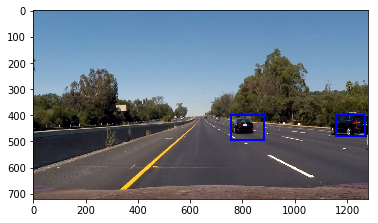

In [24]:

from moviepy.editor import VideoFileClip
from IPython.display import HTML


bboxes_list = []

video = VideoFileClip("project_video.mp4")#.subclip(0,30)
project_clip = video.fl_image(process_image) #NOTE: this function expects color images!!
video_output = "output_v5_full.mp4"
%time project_clip.write_videofile(video_output, audio=False)

#print("Bounding boxes: ", bboxes_list)

In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))